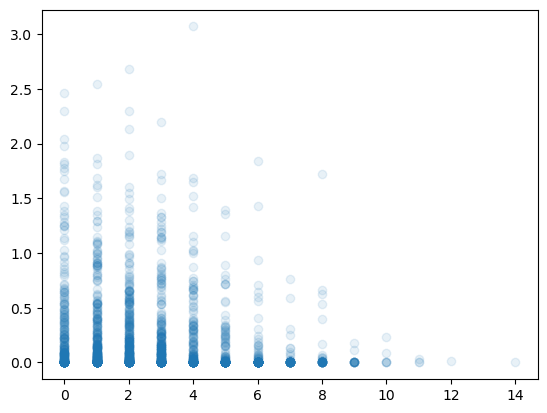

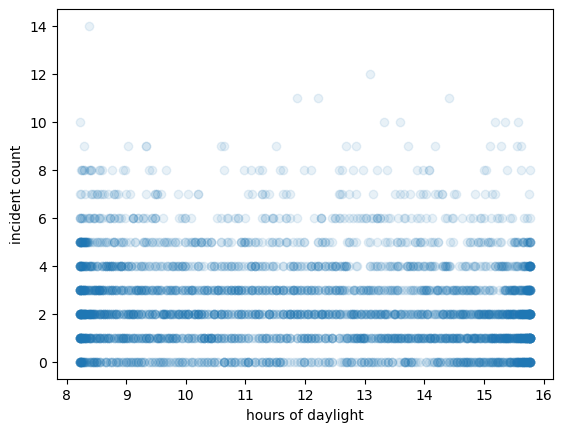

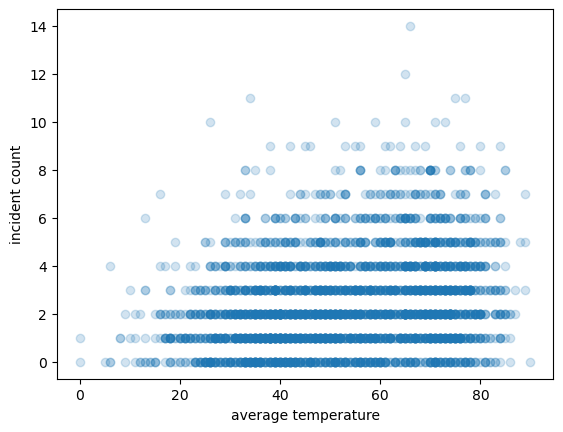

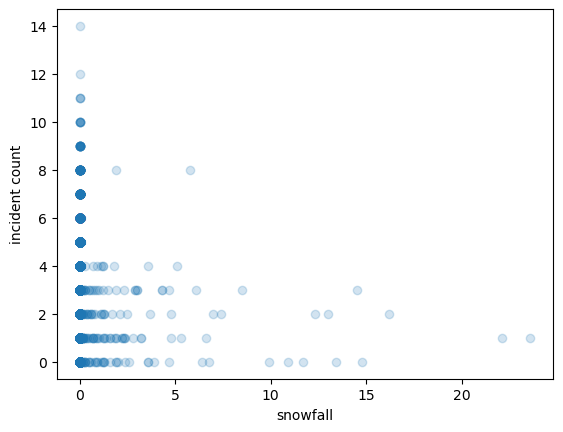

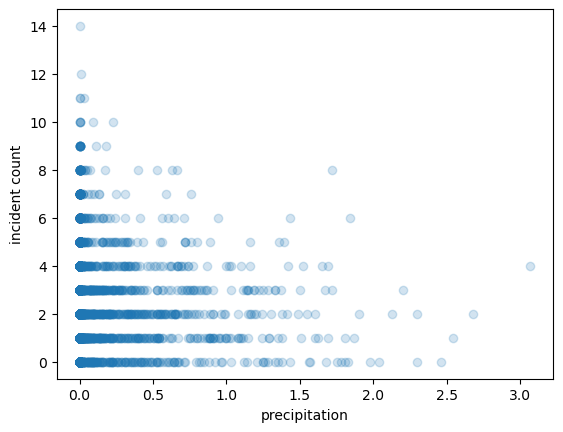

/var/folders/5x/1n063tsx6jx9wzcy34jzlqzh0000gn/T/ipykernel_36122/34638319.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  shots_daily_weather = shots_daily_weather.groupby(['day_of_week']).mean().reset_index()


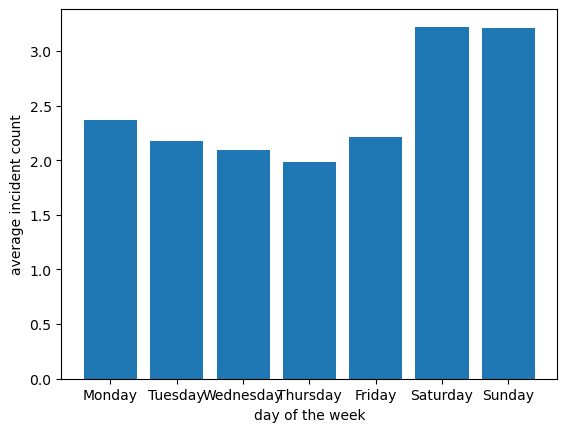

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow import keras
import tensorflow as tf

%run 'ShotsFired_EDA_aggregate_samples.ipynb'

In [2]:
# data lookin good
shots_daily.head()

,DATE,AWND,PRCP,SNOW,TAVG,district,ballistics_evidence,incident_count,daylight_hours,day_of_week,weekend,is_Monday,is_Tuesday,is_Wednesday,is_Thursday,is_Friday,is_Saturday,is_Sunday
0,2015-01-01,14.32,0.00,0.0,26,C11A15,False,2.0,12.587640,Thursday,False,False,False,False,True,False,False,False
1,2015-01-02,12.75,0.00,0.0,34,B3E13,True,2.0,12.646087,Friday,False,False,False,False,False,True,False,False
2,2015-01-03,10.29,0.62,1.4,28,B2,False,1.0,12.704440,Saturday,True,False,False,False,False,False,True,False
3,2015-01-04,8.28,0.57,0.0,38,B2B2,True,2.0,12.762693,Sunday,True,False,False,False,False,False,False,True
4,2015-01-05,22.15,0.00,0.0,40,C6,False,1.0,12.820834,Monday,False,True,False,False,False,False,False,False


In [3]:
shot_count = 4

# let's rename all values: 10, 11, 12, 14 to 10+
shots_daily['incident_count'] = shots_daily['incident_count'].replace([3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14], '3.0')

# looking at value counts, this should be move to the EDA notebook soon
print(shots_daily['incident_count'].value_counts())

incident_count
3.0    1373
2.0     721
1.0     712
0.0     465
Name: count, dtype: int64


In [4]:
# # let's convert each day of the week to a number
# # 0 = Monday, 6 = Sunday
# shots_daily['day_of_week'] = shots_daily['day_of_week'].replace(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], [0, 1, 2, 3, 4, 5, 6])
# shots_daily.head()

In [5]:
# let's create X and y

X = shots_daily[['TAVG', 'PRCP', 'SNOW', 'AWND', 'daylight_hours', 
                 'is_Monday', 'is_Tuesday', 'is_Wednesday', 'is_Thursday', 'is_Friday', 'is_Saturday', 'is_Sunday']]
# X = shots_daily[['weekend']]
y = shots_daily['incident_count']

print(X.shape)
print(y.shape)

(3271, 12)
(3271,)


In [6]:
# let's split our data into train and test sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

In [7]:
X_train = np.asarray(X_train).astype(np.float32)
X_test = np.asarray(X_test).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)

In [8]:
y_train = keras.utils.to_categorical(y_train, shot_count)
y_test = keras.utils.to_categorical(y_test, shot_count)

In [9]:
# let's run a linear regression using keras

model = keras.Sequential([
    keras.layers.Dense(100, activation='relu'),
    # keras.layers.Dropout(0.25),
    keras.layers.Dense(100, activation='relu'),
    # keras.layers.Dropout(0.25),
    keras.layers.Dense(shot_count, activation='softmax')
])

In [10]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [11]:
# model.build(input_shape=(None, input))
# model.summary()

In [12]:
callback_val_loss = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=15,
)

callback_val_accuracy = keras.callbacks.EarlyStopping(
    monitor="vall_accuracy",
    patience=10,
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.0001
)

In [13]:
batch_size = 16
epochs = 100

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[callback_val_loss, reduce_lr],
                    validation_split=0.1
                    )

Epoch 1/100


138/138 [==============================] - 0s 1ms/step - loss: 1.7078 - accuracy: 0.4227 - val_loss: 1.0894 - val_accuracy: 0.5772 - lr: 0.0100
Epoch 2/100
138/138 [==============================] - 0s 512us/step - loss: 1.2557 - accuracy: 0.4522 - val_loss: 1.0911 - val_accuracy: 0.5854 - lr: 0.0100
Epoch 3/100
138/138 [==============================] - 0s 493us/step - loss: 1.2443 - accuracy: 0.4558 - val_loss: 1.0980 - val_accuracy: 0.5569 - lr: 0.0100
Epoch 4/100
138/138 [==============================] - 0s 495us/step - loss: 1.2332 - accuracy: 0.4599 - val_loss: 1.1071 - val_accuracy: 0.5407 - lr: 0.0100
Epoch 5/100
138/138 [==============================] - 0s 723us/step - loss: 1.2413 - accuracy: 0.4703 - val_loss: 1.0751 - val_accuracy: 0.5691 - lr: 0.0100
Epoch 6/100
138/138 [==============================] - 0s 584us/step - loss: 1.2342 - accuracy: 0.4644 - val_loss: 1.0992 - val_accuracy: 0.5650 - lr: 0.0100
Epoch 7/100
138/138 [==============================] - 0s 585us/st

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               1300      
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 4)                 404       
                                                                 
Total params: 11804 (46.11 KB)
Trainable params: 11804 (46.11 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
# let's evaluate our model

model.evaluate(X_test, y_test, verbose=2)

26/26 - 0s - loss: nan - accuracy: 0.3227 - 19ms/epoch - 713us/step


[nan, 0.322738379240036]

In [16]:
# recording our results
# 3 labels: 55.3% accuracy
# 4 labels: 31.66% accuracy
# 5 labels: 22.13% accuracy
# 6 labels: 20.78% accuracy
# 7 labels: 26% accuracy
# 8 labels: 24.8% accuracy
# 9 labels: 24.9% accuracy
# 10 labels: 24.8% accuracy
# 11 labels: 25.18% accuracy
# 12 labels: 25.67% accuracy
# 13 labels: 25.41% accuracy


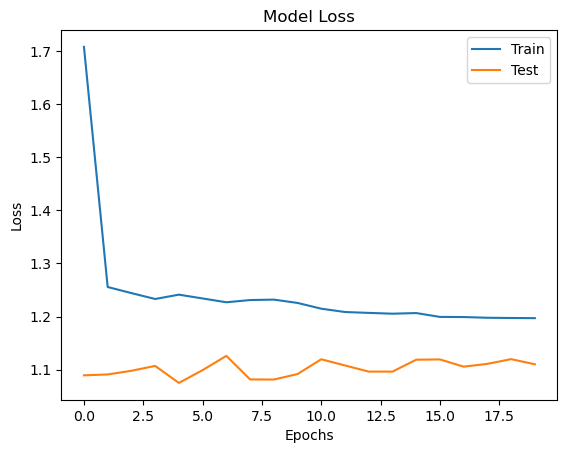

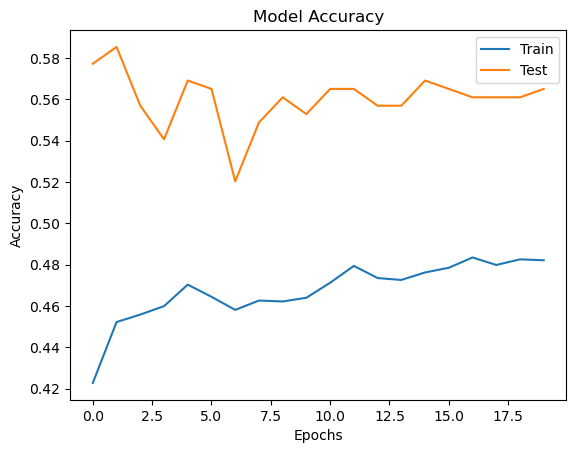

In [17]:
# let's plot our loss and accuracy

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'])
plt.show()

In [18]:
# idea: we could try  and build models for every district, since different districts may have different trends
# we might be mixing too many trends here and that's why our model is not performing well